# <center> <b> <font color='blue'> Bitcoin Prediction </center> </b> </font>

## <font color='#1f618d'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Predictions](#3)
4. [Other ways to forecast](#4)
5. [Summary](#5)
6. [References](#References)

<a name="1"></a>
## <font color='#1f618d'> <b> 1. Introduction </font> </b>


If predicting the price of Bitcoin using only the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.


This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

> 🔑 **Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

<a name="2"></a>
## <font color='#1f618d'> <b> 2. Setup </font> </b>

In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

<a name="3"></a>
## <font color='#1f618d'> <b> 3. Helper Functions </font> </b>

In [38]:
from sklearn.preprocessing import minmax_scale

# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
def plot_time_series(df):
    """
    args: df with price and block_reward
    """
    scaled_df = pd.DataFrame(minmax_scale(df[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=df.columns,
                                     index=df.index)
    scaled_df.plot(figsize=(8, 5));
    

    
    
# plot history
def plot_history(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)  # One row, two columns, first subplot
    plt.plot(history.history['loss'], label='Training Loss ')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')


    # Adjust layout
    plt.tight_layout()
    plt.show()

### Predictions

In [193]:
def forecast(model, initial_window, num_predictions, verbose=False):
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window

    # Make predictions until reaching the desired count
    for _ in range(num_predictions):
        
        # Make a one-step-ahead prediction
        pred = model.predict(current_window[np.newaxis], verbose=int(verbose))
        pred_step = pred[0][0]  # Extract the single predicted value

        # Log prediction if verbose is True
        if verbose:
            print(f"Predicting on window: {current_window} -> Prediction: {pred_step}\n")

        # Add prediction to the list
        predictions.append(pred_step)

        # Update window: slide left and insert new prediction at the end
        current_window = np.append(current_window[1:], pred_step)

    return np.array(predictions)

### Evaluation

In [45]:
# single horizon
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)


    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

<a name="3"></a>
## <font color='#1f618d'> <b> 3. Making a multivariate time series </font> </b>

In [6]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [8]:
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [9]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


#### Making a multivariate time series

Time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

> 🔑 **Note:** Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [10]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to obtain the days (indexes) for different block reward values.

This is important because if we're using multiple variables for our time series, they need to have the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

🔑 Note: When using multiple variables, make sure they have the same frequency as each other. If your variables aren't at the same frequency (e.g., Bitcoin prices are daily, but block rewards are weekly), you may need to transform them so they can be used with your model.

In [11]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [14]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [15]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [16]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


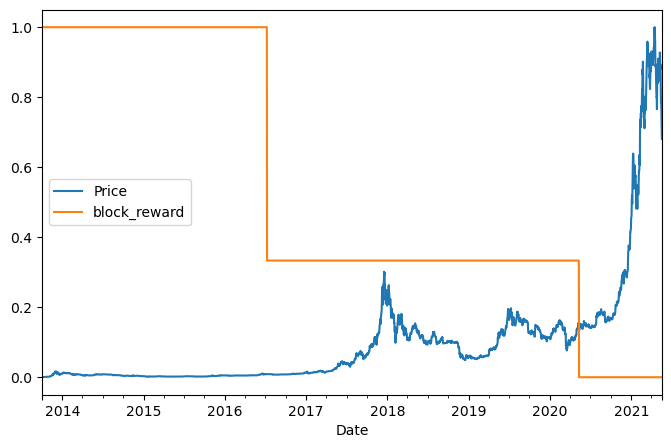

In [22]:
plot_time_series(bitcoin_prices_block)  

<a name="4"></a>
## <font color='#1f618d'> <b> 4. Pre-processing </font> </b>

#### Windowing

Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

In [23]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [24]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [25]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [27]:
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [29]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

#### Train/Test split

In [30]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

<a name="3"></a>
## <font color='#1f618d'> <b> 3. Models </font> </b>

In [32]:
tf.random.set_seed(42)

<a name="3"></a>
### <font color='#2874a6'> <b> Simple Dense </font> </b>

In [181]:
def build_compile_model_one(name, horizon):

    model = tf.keras.Sequential([
          layers.Dense(128, activation="relu"),
          layers.Dense(128, activation="relu"),
          layers.Dense(128, activation="relu"),
          layers.Dropout(0.3),
          layers.Dense(horizon)
    ], name=name)

    model.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam())

    return model


model_1 = build_compile_model_one('simple_dense', HORIZON)

In [182]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Monitors validation loss
    patience=25,           # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

history_1 = model_1.fit(X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=0,
            callbacks=[early_stopping],
            validation_data=(X_test, y_test))

You might've noticed that the model inferred the input shape of our data automatically (the data now has an extra feature). Often this will be the case, however, if you're running into shape issues, you can always explicitly define the input shape using `input_shape` parameter of the first layer in a model.

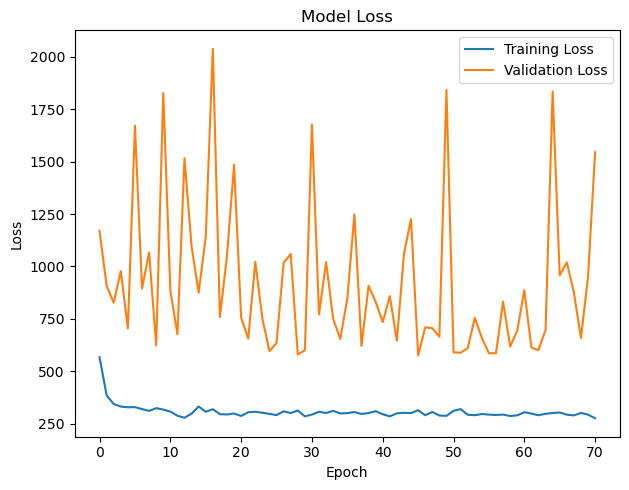

In [183]:
plot_history(history_1)

In [184]:
# Make predictions on multivariate data
model_1_preds = tf.squeeze(model_1.predict(X_test))
model_1_preds[:4]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([8922.326, 8782.699, 8997.19 , 8831.444], dtype=float32)>

In [185]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_1_preds)
model_1_results

{'mae': 575.5564, 'mse': 1214206.0, 'rmse': 1101.9102, 'mape': 2.6045651}

In [187]:
preds = forecast(model_1, X_test.to_numpy()[0], X_test.shape[0], False)

In [66]:
len(X_test)

556

In [67]:
X_test.shape[0]

556

In [71]:
ini = X_test.to_numpy()[0]

In [188]:
future_pred = model_1.predict(tf.expand_dims(ini, axis=0), verbose=0)
future_pred

array([[8922.327]], dtype=float32)

In [195]:
np.set_printoptions(precision=2)
some_preds = forecast(model_1, X_test.to_numpy()[0], 3, True)

1/1 [==============================] - 0s 16ms/step
Predicting on window: [  12.5  8794.36 9226.49 9335.75 9326.6  9369.63 9202.42 9290.9 ] -> Prediction: 8922.3271484375

1/1 [==============================] - 0s 15ms/step
Predicting on window: [8794.36 9226.49 9335.75 9326.6  9369.63 9202.42 9290.9  8922.33] -> Prediction: 9214.119140625

1/1 [==============================] - 0s 15ms/step
Predicting on window: [9226.49 9335.75 9326.6  9369.63 9202.42 9290.9  8922.33 9214.12] -> Prediction: 9300.0927734375



asi como está está mal, pues está sacando el block reward; debemos correr sólo el precio del bitcoin

In [196]:
def forecast_ok(model, initial_window, num_predictions, verbose=False):
    predictions = []
    current_window = initial_window.copy()
    
    # Extrae el primer valor de la ventana como `reward` fijo
    reward = current_window[0]
    
    # El tamaño de la ventana sin contar `reward`
    window_size = len(current_window) - 1

    for _ in range(num_predictions):
        # Realiza una predicción
        pred = model.predict(current_window[np.newaxis], verbose=int(verbose))
        pred_step = pred[0][0]

        # Muestra información si verbose está activado
        if verbose:
            print(f"Ventana actual: {current_window} -> Predicción: {pred_step}\n")

        # Agrega la predicción a la lista de predicciones
        predictions.append(pred_step)

        # Actualiza la ventana: conserva `reward` fijo y desplaza los otros valores
        current_window = np.concatenate(([reward], current_window[2:], [pred_step]))

    return np.array(predictions)


In [198]:
some_preds = forecast_ok(model_1, X_test.to_numpy()[0], 3, True)

1/1 [==============================] - 0s 14ms/step
Ventana actual: [  12.5  8794.36 9226.49 9335.75 9326.6  9369.63 9202.42 9290.9 ] -> Predicción: 8922.3271484375

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9226.49 9335.75 9326.6  9369.63 9202.42 9290.9  8922.33] -> Predicción: 9292.96875

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9335.75 9326.6  9369.63 9202.42 9290.9  8922.33 9292.97] -> Predicción: 9386.5458984375



In [199]:
new_preds = forecast_ok(model_1, X_test.to_numpy()[0], len(X_test), True)

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  8794.36 9226.49 9335.75 9326.6  9369.63 9202.42 9290.9 ] -> Predicción: 8922.3271484375

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9226.49 9335.75 9326.6  9369.63 9202.42 9290.9  8922.33] -> Predicción: 9292.96875

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9335.75 9326.6  9369.63 9202.42 9290.9  8922.33 9292.97] -> Predicción: 9386.5458984375

1/1 [==============================] - 0s 16ms/step
Ventana actual: [  12.5  9326.6  9369.63 9202.42 9290.9  8922.33 9292.97 9386.55] -> Predicción: 9349.341796875

1/1 [==============================] - 0s 18ms/step
Ventana actual: [  12.5  9369.63 9202.42 9290.9  8922.33 9292.97 9386.55 9349.34] -> Predicción: 9373.5400390625

1/1 [==============================] - 0s 17ms/step
Ventana actual: [  12.5  9202.42 9290.9  8922.33 9292.97 9386.55 9349.34 9373.54] -> Predicción: 9246.0146484375

1/1 [=====

1/1 [==============================] - 0s 16ms/step
Ventana actual: [  12.5  9568.59 9527.53 9447.54 9352.21 9334.32 9448.57 9568.35] -> Predicción: 9592.0849609375

1/1 [==============================] - 0s 17ms/step
Ventana actual: [  12.5  9527.53 9447.54 9352.21 9334.32 9448.57 9568.35 9592.08] -> Predicción: 9536.36328125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [  12.5  9447.54 9352.21 9334.32 9448.57 9568.35 9592.08 9536.36] -> Predicción: 9444.3369140625

1/1 [==============================] - 0s 16ms/step
Ventana actual: [  12.5  9352.21 9334.32 9448.57 9568.35 9592.08 9536.36 9444.34] -> Predicción: 9366.8798828125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [  12.5  9334.32 9448.57 9568.35 9592.08 9536.36 9444.34 9366.88] -> Predicción: 9393.732421875

1/1 [==============================] - 0s 17ms/step
Ventana actual: [  12.5  9448.57 9568.35 9592.08 9536.36 9444.34 9366.88 9393.73] -> Predicción: 9520.2490234375

1/1 [==

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9570.65 9587.59 9682.31 9775.2  9791.85 9730.82 9642.38] -> Predicción: 9598.9443359375

1/1 [==============================] - 0s 17ms/step
Ventana actual: [  12.5  9587.59 9682.31 9775.2  9791.85 9730.82 9642.38 9598.94] -> Predicción: 9644.3388671875

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9682.31 9775.2  9791.85 9730.82 9642.38 9598.94 9644.34] -> Predicción: 9746.0205078125

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9775.2  9791.85 9730.82 9642.38 9598.94 9644.34 9746.02] -> Predicción: 9819.19921875

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9791.85 9730.82 9642.38 9598.94 9644.34 9746.02 9819.2 ] -> Predicción: 9809.3994140625

1/1 [==============================] - 0s 15ms/step
Ventana actual: [  12.5  9730.82 9642.38 9598.94 9644.34 9746.02 9819.2  9809.4 ] -> Predicción: 9733.626953125

1/1 [==

1/1 [==============================] - 0s 16ms/step
Ventana actual: [  12.5  9991.19 9994.61 9931.67 9857.57 9835.62 9888.54 9976.95] -> Predicción: 10030.8544921875

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5   9994.61  9931.67  9857.57  9835.62  9888.54  9976.95 10030.85] -> Predicción: 10010.7353515625

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5   9931.67  9857.57  9835.62  9888.54  9976.95 10030.85 10010.74] -> Predicción: 9938.4658203125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5   9857.57  9835.62  9888.54  9976.95 10030.85 10010.74  9938.47] -> Predicción: 9876.2568359375

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5   9835.62  9888.54  9976.95 10030.85 10010.74  9938.47  9876.26] -> Predicción: 9878.33984375

1/1 [==============================] - 0s 19ms/step
Ventana actual: [   12.5   9888.54  9976.95 10030.85 10010.74  9938.47  9876.26  9878.

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  10210.53 10201.96 10141.51 10082.5  10076.63 10132.95 10209.15] -> Predicción: 10246.142578125

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  10201.96 10141.51 10082.5  10076.63 10132.95 10209.15 10246.14] -> Predicción: 10218.16796875

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  10141.51 10082.5  10076.63 10132.95 10209.15 10246.14 10218.17] -> Predicción: 10152.99609375

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  10082.5  10076.63 10132.95 10209.15 10246.14 10218.17 10153.  ] -> Predicción: 10107.4326171875

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  10076.63 10132.95 10209.15 10246.14 10218.17 10153.   10107.43] -> Predicción: 10122.462890625

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  10132.95 10209.15 10246.14 10218.17 10153.   10107.43

1/1 [==============================] - 0s 18ms/step
Ventana actual: [   12.5  10432.83 10415.6  10360.   10315.33 10321.87 10378.53 10442.65] -> Predicción: 10465.4267578125

1/1 [==============================] - 0s 18ms/step
Ventana actual: [   12.5  10415.6  10360.   10315.33 10321.87 10378.53 10442.65 10465.43] -> Predicción: 10432.8642578125

1/1 [==============================] - 0s 18ms/step
Ventana actual: [   12.5  10360.   10315.33 10321.87 10378.53 10442.65 10465.43 10432.86] -> Predicción: 10376.240234375

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  10315.33 10321.87 10378.53 10442.65 10465.43 10432.86 10376.24] -> Predicción: 10345.4912109375

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  10321.87 10378.53 10442.65 10465.43 10432.86 10376.24 10345.49] -> Predicción: 10369.71875

1/1 [==============================] - 0s 19ms/step
Ventana actual: [   12.5  10378.53 10442.65 10465.43 10432.86 10376.24 10345.49

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  10658.91 10636.11 10586.83 10555.17 10571.   10625.7  10678.2 ] -> Predicción: 10689.505859375

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  10636.11 10586.83 10555.17 10571.   10625.7  10678.2  10689.51] -> Predicción: 10655.1220703125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  10586.83 10555.17 10571.   10625.7  10678.2  10689.51 10655.12] -> Predicción: 10607.64453125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  10555.17 10571.   10625.7  10678.2  10689.51 10655.12 10607.64] -> Predicción: 10589.6494140625

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  10571.   10625.7  10678.2  10689.51 10655.12 10607.64 10589.65] -> Predicción: 10620.0146484375

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  10625.7  10678.2  10689.51 10655.12 10607.64 10589

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  10889.51 10863.75 10821.58 10801.37 10823.82 10874.9  10916.59] -> Predicción: 10919.0068359375

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  10863.75 10821.58 10801.37 10823.82 10874.9  10916.59 10919.01] -> Predicción: 10884.974609375

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  10821.58 10801.37 10823.82 10874.9  10916.59 10919.01 10884.97] -> Predicción: 10846.6923828125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  10801.37 10823.82 10874.9  10916.59 10919.01 10884.97 10846.69] -> Predicción: 10839.373046875

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  10823.82 10874.9  10916.59 10919.01 10884.97 10846.69 10839.37] -> Predicción: 10873.318359375

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  10874.9  10916.59 10919.01 10884.97 10846.69 10839

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  11125.26 11098.64 11063.91 11053.47 11080.21 11126.58 11158.55] -> Predicción: 11154.41796875

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11098.64 11063.91 11053.47 11080.21 11126.58 11158.55 11154.42] -> Predicción: 11122.3828125

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  11063.91 11053.47 11080.21 11126.58 11158.55 11154.42 11122.38] -> Predicción: 11092.9384765625

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11053.47 11080.21 11126.58 11158.55 11154.42 11122.38 11092.94] -> Predicción: 11094.251953125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11080.21 11126.58 11158.55 11154.42 11122.38 11092.94 11094.25] -> Predicción: 11129.697265625

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11126.58 11158.55 11154.42 11122.38 11092.94 11094.25 

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11366.67 11340.8  11313.43 11311.1  11340.2  11381.24 11404.75] -> Predicción: 11396.1103515625

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  11340.8  11313.43 11311.1  11340.2  11381.24 11404.75 11396.11] -> Predicción: 11367.20703125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11313.43 11311.1  11340.2  11381.24 11404.75 11396.11 11367.21] -> Predicción: 11345.9736328125

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  11311.1  11340.2  11381.24 11404.75 11396.11 11367.21 11345.97] -> Predicción: 11354.0263671875

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  11340.2  11381.24 11404.75 11396.11 11367.21 11345.97 11354.03] -> Predicción: 11389.3330078125

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  11381.24 11404.75 11396.11 11367.21 11345.97 1135

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  11614.12 11590.19 11569.83 11574.   11603.89 11639.38 11655.75] -> Predicción: 11644.337890625

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11590.19 11569.83 11574.   11603.89 11639.38 11655.75 11644.34] -> Predicción: 11619.306640625

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11569.83 11574.   11603.89 11639.38 11655.75 11644.34 11619.31] -> Predicción: 11605.4560546875

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  11574.   11603.89 11639.38 11655.75 11644.34 11619.31 11605.46] -> Predicción: 11618.548828125

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11603.89 11639.38 11655.75 11644.34 11619.31 11605.46 11618.55] -> Predicción: 11652.4775390625

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  11639.38 11655.75 11644.34 11619.31 11605.46 11618

1/1 [==============================] - 0s 15ms/step
Ventana actual: [   12.5  11867.88 11846.72 11832.81 11842.   11871.48 11901.5  11912.01] -> Predicción: 11899.275390625

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11846.72 11832.81 11842.   11871.48 11901.5  11912.01 11899.28] -> Predicción: 11878.5146484375

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  11832.81 11842.   11871.48 11901.5  11912.01 11899.28 11878.51] -> Predicción: 11871.1259765625

1/1 [==============================] - 0s 17ms/step
Ventana actual: [   12.5  11842.   11871.48 11901.5  11912.01 11899.28 11878.51 11871.13] -> Predicción: 11887.74609375

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11871.48 11901.5  11912.01 11899.28 11878.51 11871.13 11887.75] -> Predicción: 11919.4248046875

1/1 [==============================] - 0s 16ms/step
Ventana actual: [   12.5  11901.5  11912.01 11899.28 11878.51 11871.13 11887

In [200]:
res = evaluate_preds(y_true=y_test,
                                 y_pred=new_preds)
res

{'mae': 10930.786, 'mse': 374094820.0, 'rmse': 19341.531, 'mape': 33.764984}

## LSTM

In [213]:
def build_compile_model_5(name, window_size=WINDOW_SIZE, horizon=HORIZON, num_features=2):
    inputs = layers.Input(shape=(window_size+1,))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
        # expand input dimension to be compatible with LSTM
    x = layers.LSTM(128, activation='relu')(x)
    output = layers.Dense(horizon)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name=name)
    
    model.compile(loss='mae',
                 optimizer=tf.keras.optimizers.Adam())
    
    return model


model_5 = build_compile_model_5('model_5_lstm')

In [214]:
history_5 = model_5.fit(X_train,
            y_train,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(X_test, y_test))

ASÍ COMO ESTÁ no son realmente 2 caract. sino más bien una sola, voy a encaralo bienluego.


Además, a muchos precios le poníea el mismo bloque que no está bien.